In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import random
import warnings

import pandas as pd
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
import time

start_time = time.time()
tcurrent   = start_time

In [4]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../00.data/extracted/stage1_train/'
TEST_PATH = '../00.data/extracted/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed_value = 423 
random.seed = seed_value
np.random.seed = seed_value

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [7]:
print('Getting and resizing train images and masks ... ')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:09<00:00,  5.16it/s]


In [8]:
# Get and resize test images

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sizes_test = []

In [9]:
print('Getting and resizing test images ... ')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 65.89it/s]

Done!


#### Check if training data looks all right

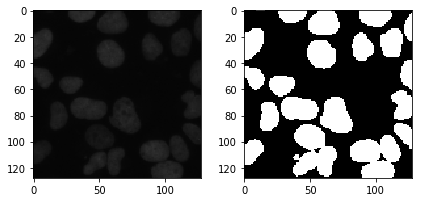

In [10]:
ix = random.randint(0, len(train_ids))

plt.subplot(121)
imshow(X_train[ix])
plt.subplot(122)
imshow(np.squeeze(Y_train[ix]));

#### Define IoU metric

In [11]:
def mean_iou(y_true, y_pred):
    
    prec = []
    
    for t in np.arange(0.5, 1.0, 0.05):
        
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        
        with tf.control_dependencies([up_opt]):
            
            score = tf.identity(score)
            
        prec.append(score)
        
    return K.mean(K.stack(prec), axis=0)

### Build U-Net model

In [12]:
import tensorflow as tf

In [13]:
K.clear_session()

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 8)  584         conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [14]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[mean_iou])

In [15]:
model_path = '../02.model/deeper_unet.h5'

In [19]:
from keras.preprocessing.image import random_rotation,random_zoom,random_shift

trainGen,maskGen = 

In [38]:
# Fit model
earlystopper = EarlyStopping(patience=100, verbose=1)
checkpointer = ModelCheckpoint(model_path, verbose=1, save_best_only=True)

# setup
n_epochs  = 1000
val_split = 0.12

# fitting
results = model.fit(X_train*1.0/255, 
                    Y_train, 
                    validation_split=val_split, 
                    batch_size=8,
                    epochs=n_epochs, 
                    callbacks=[earlystopper, checkpointer])

Train on 589 samples, validate on 81 samples
Epoch 1/1000
589/589 [==============================] - 18s 31ms/step - loss: 0.5347 - mean_iou: 0.4177 - val_loss: 0.4549 - val_mean_iou: 0.4243
Epoch 2/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.3449 - mean_iou: 0.4238 - val_loss: 0.3367 - val_mean_iou: 0.4239
Epoch 3/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.2438 - mean_iou: 0.4274 - val_loss: 0.2610 - val_mean_iou: 0.4396
Epoch 4/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.1856 - mean_iou: 0.4588 - val_loss: 0.1726 - val_mean_iou: 0.4864
Epoch 5/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.1286 - mean_iou: 0.5149 - val_loss: 0.1385 - val_mean_iou: 0.5417
Epoch 6/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.1122 - mean_iou: 0.5649 - val_loss: 0.1291 - val_mean_iou: 0.5840
Epoch 7/1000
589/589 [==============================] - 13s 22ms/step - loss: 0

589/589 [==============================] - 13s 22ms/step - loss: 0.0718 - mean_iou: 0.7846 - val_loss: 0.0875 - val_mean_iou: 0.7861
Epoch 28/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0734 - mean_iou: 0.7873 - val_loss: 0.0901 - val_mean_iou: 0.7887
Epoch 29/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0728 - mean_iou: 0.7901 - val_loss: 0.1105 - val_mean_iou: 0.7913
Epoch 30/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0734 - mean_iou: 0.7924 - val_loss: 0.0864 - val_mean_iou: 0.7936
Epoch 31/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0739 - mean_iou: 0.7946 - val_loss: 0.0951 - val_mean_iou: 0.7957
Epoch 32/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0740 - mean_iou: 0.7967 - val_loss: 0.0877 - val_mean_iou: 0.7977
Epoch 33/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0700 - mean_iou: 0.7988 - val_loss: 0.0879 - val_me

Epoch 57/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0646 - mean_iou: 0.8291 - val_loss: 0.0817 - val_mean_iou: 0.8295
Epoch 58/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0646 - mean_iou: 0.8298 - val_loss: 0.0788 - val_mean_iou: 0.8302
Epoch 59/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0636 - mean_iou: 0.8306 - val_loss: 0.0808 - val_mean_iou: 0.8309
Epoch 60/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0624 - mean_iou: 0.8313 - val_loss: 0.0799 - val_mean_iou: 0.8317
Epoch 61/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0627 - mean_iou: 0.8320 - val_loss: 0.0820 - val_mean_iou: 0.8324
Epoch 62/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0663 - mean_iou: 0.8328 - val_loss: 0.0823 - val_mean_iou: 0.8331
Epoch 63/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0630 - mean_iou: 0.8334 - val_loss: 0

Epoch 87/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0598 - mean_iou: 0.8448 - val_loss: 0.0746 - val_mean_iou: 0.8450
Epoch 88/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0600 - mean_iou: 0.8452 - val_loss: 0.0788 - val_mean_iou: 0.8454
Epoch 89/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0593 - mean_iou: 0.8456 - val_loss: 0.0755 - val_mean_iou: 0.8458
Epoch 90/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0605 - mean_iou: 0.8460 - val_loss: 0.0806 - val_mean_iou: 0.8462
Epoch 91/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0610 - mean_iou: 0.8463 - val_loss: 0.0803 - val_mean_iou: 0.8465
Epoch 92/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0591 - mean_iou: 0.8467 - val_loss: 0.0772 - val_mean_iou: 0.8469
Epoch 93/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0605 - mean_iou: 0.8471 - val_loss: 0

Epoch 117/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0552 - mean_iou: 0.8549 - val_loss: 0.0814 - val_mean_iou: 0.8551
Epoch 118/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0572 - mean_iou: 0.8552 - val_loss: 0.0819 - val_mean_iou: 0.8554
Epoch 119/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0540 - mean_iou: 0.8555 - val_loss: 0.0735 - val_mean_iou: 0.8557
Epoch 120/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0533 - mean_iou: 0.8558 - val_loss: 0.0814 - val_mean_iou: 0.8560
Epoch 121/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0544 - mean_iou: 0.8561 - val_loss: 0.0760 - val_mean_iou: 0.8562
Epoch 122/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0530 - mean_iou: 0.8564 - val_loss: 0.0771 - val_mean_iou: 0.8566
Epoch 123/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0556 - mean_iou: 0.8567 - val_

589/589 [==============================] - 13s 22ms/step - loss: 0.0535 - mean_iou: 0.8626 - val_loss: 0.0781 - val_mean_iou: 0.8627
Epoch 148/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0497 - mean_iou: 0.8628 - val_loss: 0.0833 - val_mean_iou: 0.8630
Epoch 149/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0473 - mean_iou: 0.8631 - val_loss: 0.0781 - val_mean_iou: 0.8632
Epoch 150/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0468 - mean_iou: 0.8634 - val_loss: 0.0823 - val_mean_iou: 0.8635
Epoch 151/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0514 - mean_iou: 0.8636 - val_loss: 0.0834 - val_mean_iou: 0.8637
Epoch 152/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0485 - mean_iou: 0.8638 - val_loss: 0.0782 - val_mean_iou: 0.8640
Epoch 153/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0491 - mean_iou: 0.8641 - val_loss: 0.0785 - 

Epoch 178/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0431 - mean_iou: 0.8697 - val_loss: 0.0945 - val_mean_iou: 0.8698
Epoch 179/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0466 - mean_iou: 0.8699 - val_loss: 0.0825 - val_mean_iou: 0.8700
Epoch 180/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0424 - mean_iou: 0.8701 - val_loss: 0.0803 - val_mean_iou: 0.8702
Epoch 181/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0423 - mean_iou: 0.8703 - val_loss: 0.0795 - val_mean_iou: 0.8705
Epoch 182/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0427 - mean_iou: 0.8706 - val_loss: 0.0818 - val_mean_iou: 0.8707
Epoch 183/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0430 - mean_iou: 0.8708 - val_loss: 0.0861 - val_mean_iou: 0.8709
Epoch 184/1000
589/589 [==============================] - 13s 22ms/step - loss: 0.0436 - mean_iou: 0.8710 - val_

#### Predict on train, val and test

In [39]:
model = load_model(model_path, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)]*1.0/255, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):]*1.0/255, verbose=1)
preds_test = model.predict(X_test*1.0/255, verbose=1)

65/65 [==============================] - 0s 3ms/step


#### Threshold predictions

In [40]:
thr = 0.50
preds_train_t = (preds_train > thr).astype(np.uint8)
preds_val_t = (preds_val > thr).astype(np.uint8)
preds_test_t = (preds_test > thr).astype(np.uint8)

#### Create list of upsampled test masks

In [41]:
preds_test_upsampled = []

for i in range(len(preds_test)):
    
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant',
                                       preserve_range=True))

#### Perform a sanity check on some random training samples

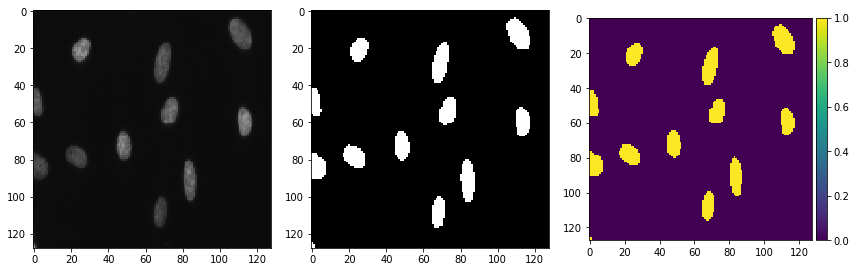

In [42]:
ix = random.randint(0, len(preds_train_t))

plt.figure(figsize=(12,6))

plt.subplot(131)
imshow(X_train[ix])
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix]));

#### Perform a sanity check on some random validation samples

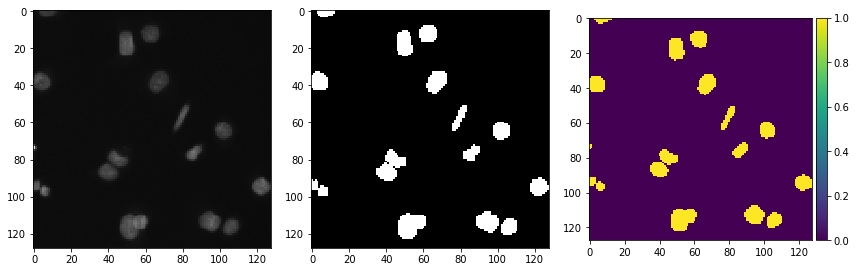

In [43]:
ix = random.randint(0, len(preds_val_t))

plt.figure(figsize=(12,6))

plt.subplot(131)
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.subplot(132)
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.subplot(133)
imshow(np.squeeze(preds_val_t[ix]));

#### Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

In [44]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [45]:
new_test_ids = []
rles = []

for n, id_ in enumerate(test_ids):
    
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

#### Create submission DataFrame

In [49]:
prediction_prefix = 'deeper_unet_'

In [50]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

fname ='../04.predictions/'+prediction_prefix+str(n_epochs)+' vsplit '+str(val_split)+' seed '+str(seed_value)+' thr'+str(thr)+'.csv'

sub.to_csv(fname, index=False)

nm=(time.time() - start_time)/60
print ("Total time %s min" % nm)

Total time 58.5050112009 min
